如果你像我一样是在Google Colab上运行这个notebook，就需要先执行pretrain部分，搭建必须的环境。

### Pretrain

In [1]:
!ls

sample_data


In [10]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!mkdir ~/.kaggle -p
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [2]:
!git config --global user.email 'nikshuang@163.com'
!git config --global user.name 'Alex Huang'
!pip install --upgrade pip
!pip3 install torch torchvision
!pip install fastai && pip uninstall fastai -y
!git clone https://github.com/fastai/fastai.git src/fastai
!ln -s src/fastai/fastai .
!pip install kaggle

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.0)
    100% |████████████████████████████████| 519.5MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59166000 @  0x7f0ec7e421c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 11.3MB/s 
    100% |████████████████████████████████| 2.0MB 3.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 122kB 5.4MB/s 
    100% |████████████████████████████████| 1.5MB 6.9MB/s 
    100% |████████████████████████████████| 51kB 16.0MB/s 
    100% |████████████████████████████████| 112kB 18.0MB/s 
    100% |██████████████████████████████

### Setup

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip
# torch.cuda.set_device(3)

In [0]:
torch.backends.cudnn.benchmark=True

In [0]:
PATH = Path('data/celeba/')
CSV_PATH = PATH/'files.csv'
CSV_SMALL_PATH = PATH/'files_small.csv'
TRN_DN = 'img_align_celeba'
IMG_PATH = PATH/TRN_DN
TMP_PATH = PATH/'tmp'
os.makedirs(TMP_PATH, exist_ok=True)

In [13]:
!kaggle datasets download -d jessicali9530/celeba-dataset -p {PATH}

 99%|█████████████████████████████████████▋| 1.20G/1.21G [00:27<00:00, 75.1MB/s]
100%|██████████████████████████████████████| 1.21G/1.21G [00:28<00:00, 46.5MB/s]


In [0]:
!ls {PATH}/*.zip | xargs -IX unzip -q X -d {PATH}
!unzip -q {PATH}/img_align_celeba.zip -d {PATH}

In [0]:
files = PATH.glob('**/*.jpg')
with CSV_PATH.open('w') as fp:
  for f in files: fp.write(f'{f.relative_to(IMG_PATH)},0\n')

sample dataset, 10% of the original dataset, to speed up trainning model.

In [0]:
files = PATH.glob('**/*.jpg')
with CSV_SMALL_PATH.open('w') as fp:
  for f in files:
    if np.random.random() < 0.1: fp.write(f'{f.relative_to(IMG_PATH)},0\n')

### Dataset

In [0]:
bs = 64
sz = 128

tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, TRN_DN, CSV_SMALL_PATH, bs, tfms=tfms,
                                  skip_header=False, continuous=True)

In [134]:
len(md.trn_ds)

16366

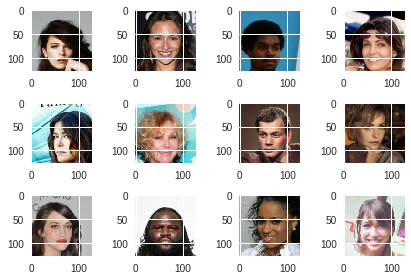

In [135]:
x, _ = next(iter(md.trn_dl))
x_ims = md.trn_ds.denorm(x)

fig, axes = plt.subplots(3, 4, figsize=(6, 4))
for i, ax in enumerate(axes.flat):
  ax.imshow(x_ims[i])
plt.tight_layout()

### Model

Discriminator

In [0]:
class ConvBlock(nn.Module):
  def __init__(self, in_c, out_c, ks, stride, bn=True):
    super().__init__()
    padding = ks // 2 // stride
    self.conv = nn.Conv2d(in_c, out_c, ks, stride, padding, bias=False)
    self.bn = nn.BatchNorm2d(out_c) if bn else None
    self.relu = nn.LeakyReLU(0.2, inplace=True)
  
  def forward(self, x):
    x = self.relu(self.conv(x))
    return self.bn(x) if self.bn else x


class DCGAN_D(nn.Module):
  def __init__(self, sz, in_c, nf, num_extra_layers=0):
    super().__init__()
    assert sz % 16 == 0, 'sz must be a multipe by 16.'
   
    self.initial = ConvBlock(in_c, nf, 4, 2, bn=False)
    grid_sz = sz / 2
    self.extra = nn.Sequential(*[ConvBlock(nf, nf, 3, 1) for o in range(num_extra_layers)])
    
    layers = []
    while grid_sz > 4:
      layers.append(ConvBlock(nf, nf * 2, 4, 2))
      grid_sz /= 2; nf *= 2
    self.pyramid = nn.Sequential(*layers)
    
    self.final = nn.Conv2d(nf, 1, 4, 1, 0, bias=False)
  
  def forward(self, x):
    x = self.initial(x)
    x = self.extra(x)
    x = self.pyramid(x)
    return self.final(x).mean().view(1)

Generator

In [0]:
class DeconvBlock(nn.Module):
  def __init__(self, in_c, out_c, ks, stride, pad, bn=True):
    super().__init__()
    self.conv = nn.ConvTranspose2d(in_c, out_c, ks, stride=stride, padding=pad, bias=False)
    self.bn = nn.BatchNorm2d(out_c)
    self.relu = nn.ReLU(inplace=True)
    
  def forward(self, x):
    x = self.relu(self.conv(x))
    return self.bn(x) if bn else x


class DCGAN_G(nn.Module):
  def __init__(self, sz, in_c, nf, num_extra_layers=0):
    super().__init__()
    assert sz % 16 == 0, 'sz must be a multipe by 16.'
    i = 4; nf //= 2
    while i != sz:
      nf *= 2; i *= 2
    
    self.initial = DeconvBlock(in_c, nf, 4, 1, 0)
    
    layers = []
    curr_sz = 4
    while curr_sz < (sz // 2):
      layers.append(DeconvBlock(nf, nf // 2, 4, 2, 1))
      curr_sz *= 2; nf //= 2
    self.pyramid = nn.Sequential(*layers)
    self.extra = nn.Sequential(*[DeconvBlock(nf, nf, 3, 1, 1) for i in range(num_extra_layers)])
    self.final = nn.ConvTranspose2d(nf, 3, 4, 2, 1, bias=False)
  
  def forward(self, x):
    x = self.initial(x)
    x = self.pyramid(x)
    x = self.extra(x)
    return F.tanh(self.final(x))

In [0]:
sz, nz = 64, 100

# generator
net_G = DCGAN_G(sz, nz, 64, 1).cuda()
# discriminator
net_D = DCGAN_D(sz, 3, 64, 1).cuda()

Noise Generator

In [0]:
def gen_noise(bs):
  return V(torch.zeros((bs, nz, 1, 1)).normal_(0, 1))

torch.Size([4, 3, 64, 64])

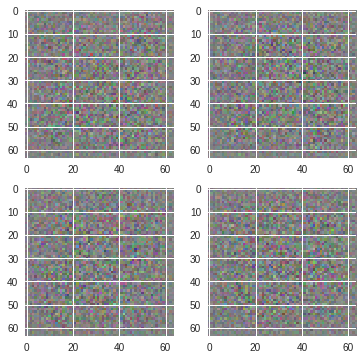

In [140]:
fake = net_G(gen_noise(4))
display(fake.size())
fake_ims = md.trn_ds.denorm(fake)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(fake_ims[i])

### Training

In [0]:
lr = 5e-5

opt_G = optim.RMSprop(net_G.parameters(), lr=lr)
opt_D = optim.RMSprop(net_D.parameters(), lr=lr)

In [0]:
ncritic = 5

def WGAN_fit(md, niter):
  net_G.train(True)
  net_D.train(True)
  gen_iterations = 0
  
  for epoch in range(niter):
    data_iter = iter(md.trn_dl)
    i, n = 0, len(md.trn_dl)
    with tqdm(total=n) as pbar:
      while i < n:
        set_trainable(net_D, True)
        set_trainable(net_G, False)
        j = 0
        while i < n and j < ncritic:
          for p in net_D.parameters(): p.data.clamp_(-0.01, 0.01)
          real = V(next(data_iter)[0])
          real_loss = net_D(real)
          fake = net_G(gen_noise(real.size(0)))
          fake_loss = net_D(V(fake.data))
          net_D.zero_grad()
          d_loss = real_loss - fake_loss
          d_loss.backward()
          opt_D.step()
          i += 1; j += 1
          pbar.update()
        
        set_trainable(net_D, False)
        set_trainable(net_G, True)
        net_G.zero_grad()
        g_loss = net_D(net_G(gen_noise(bs)))
        g_loss.backward()
        opt_G.step()
        gen_iterations += 1
      
    print(f'd_loss: {to_np(d_loss)}; g_loss: {to_np(g_loss)}; '
          f'real_loss: {to_np(real_loss)}; fake_loss: {to_np(fake_loss)}')

In [144]:
WGAN_fit(md, 5)

100%|██████████| 256/256 [01:12<00:00,  1.43it/s]
d_loss: [-1.06658]; g_loss: [0.81221]; real_loss: [-0.27118]; fake_loss: [0.7954]
100%|██████████| 256/256 [01:09<00:00,  3.91it/s]
d_loss: [-1.09587]; g_loss: [0.84473]; real_loss: [-0.26713]; fake_loss: [0.82875]
100%|██████████| 256/256 [01:10<00:00,  3.89it/s]
d_loss: [-1.04561]; g_loss: [0.82418]; real_loss: [-0.23558]; fake_loss: [0.81003]
100%|██████████| 256/256 [01:09<00:00,  3.92it/s]
d_loss: [-1.06523]; g_loss: [0.8402]; real_loss: [-0.24339]; fake_loss: [0.82184]
100%|██████████| 256/256 [01:10<00:00,  3.89it/s]
d_loss: [-1.01388]; g_loss: [0.82767]; real_loss: [-0.22356]; fake_loss: [0.79032]


In [0]:
lr = 1e-4

opt_G = optim.RMSprop(net_G.parameters(), lr=lr)
opt_D = optim.RMSprop(net_D.parameters(), lr=lr)

In [100]:
WGAN_fit(md, 10)

100%|██████████| 2533/2533 [07:16<00:00,  7.29it/s]
d_loss: [-0.71795]; g_loss: [0.25149]; real_loss: [-0.2049]; fake_loss: [0.51305]
100%|██████████| 2533/2533 [07:17<00:00,  7.24it/s]
d_loss: [-0.66687]; g_loss: [0.22367]; real_loss: [-0.27482]; fake_loss: [0.39205]
100%|██████████| 2533/2533 [07:15<00:00,  7.34it/s]
d_loss: [-0.62798]; g_loss: [0.41359]; real_loss: [-0.35229]; fake_loss: [0.27569]
100%|██████████| 2533/2533 [07:15<00:00,  7.24it/s]
d_loss: [-0.43533]; g_loss: [0.1597]; real_loss: [-0.01642]; fake_loss: [0.41891]
100%|██████████| 2533/2533 [07:16<00:00,  7.28it/s]
d_loss: [-0.4477]; g_loss: [0.42561]; real_loss: [-0.48342]; fake_loss: [-0.03572]
100%|██████████| 2533/2533 [07:17<00:00,  7.26it/s]
d_loss: [-0.29932]; g_loss: [0.39118]; real_loss: [-0.34904]; fake_loss: [-0.04972]
100%|██████████| 2533/2533 [07:17<00:00,  7.27it/s]
d_loss: [-0.44208]; g_loss: [0.1606]; real_loss: [-0.1102]; fake_loss: [0.33189]
100%|██████████| 2533/2533 [07:16<00:00,  7.27it/s]
d_loss

### Test

In [0]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [0]:
fixed_noise = gen_noise(bs)

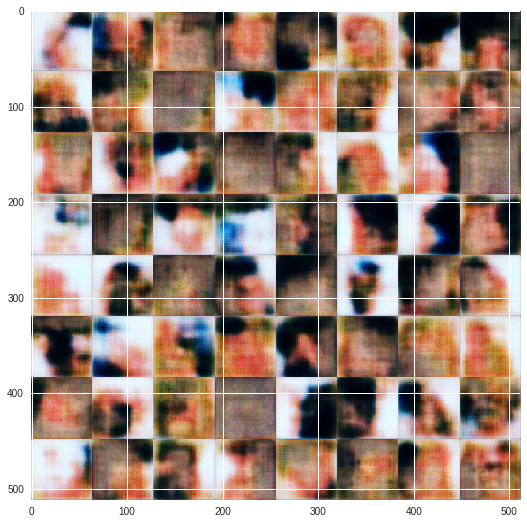

In [148]:
net_D.eval(); net_G.eval();
fake = net_G(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8))

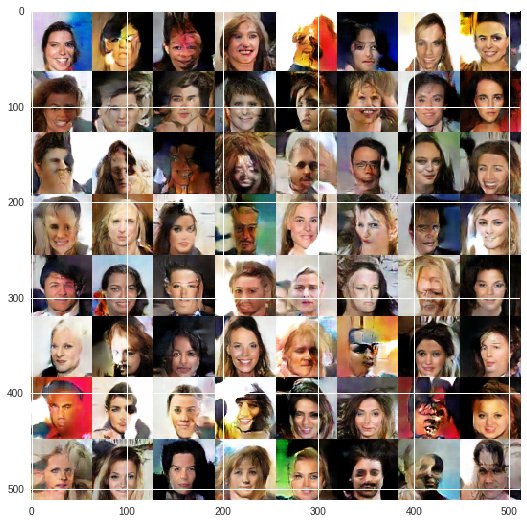

In [102]:
net_D.eval(); net_G.eval();
fake = net_G(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8))